## Relation of Price with size, location and neighborhood

In [1]:
pip install --upgrade category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 3.6 MB/s 


In [2]:
import warnings
from glob import glob

import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
def wrangle(filepath):
    # Read Excel file
    df = pd.read_excel(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Get place name
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)
    
    # Drop features with high null counts
    df.drop(columns=["floor", "expenses"], inplace=True)
    
    # Drop high and low-cardinality categorical variables
    df.drop(columns=["operation", "property_type", "currency", "properati_url"], inplace=True)

    # Drop the leaky columns
    df.drop(columns=[
        'price',
        'price_aprox_local_currency',
        'price_per_m2',
        'price_usd_per_m2'
    ], 
            inplace=True
)
    
    # Drop columns with multicollinearity
    df.drop(columns=["surface_total_in_m2", "rooms"], inplace=True)
    
    return df

In [4]:
files = glob("/content/data_*.xlsx")
files

['/content/data_5.xlsx',
 '/content/data_3.xlsx',
 '/content/data_2.xlsx',
 '/content/data_4.xlsx',
 '/content/data_1.xlsx']

In [12]:
frames = [wrangle(file) for file in files]


In [13]:
frames[0].head()

,Unnamed: 0,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
3,4,112000.0,60.0,-34.564676,-58.455720,Belgrano
9,10,76500.0,36.0,-34.618830,-58.437779,Caballito
18,19,90000.0,100.0,-34.577168,-58.538654,Belgrano
20,21,159900.0,77.0,-34.571526,-58.455637,Colegiales
21,22,123875.0,50.0,-34.578688,-58.457358,Colegiales


In [6]:
df = pd.concat(frames, ignore_index=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             6582 non-null   int64  
 1   price_aprox_usd        6582 non-null   float64
 2   surface_covered_in_m2  6582 non-null   float64
 3   lat                    6316 non-null   float64
 4   lon                    6316 non-null   float64
 5   neighborhood           6582 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 308.7+ KB
None


,Unnamed: 0,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
0,4,112000.0,60.0,-34.564676,-58.455720,Belgrano
1,10,76500.0,36.0,-34.618830,-58.437779,Caballito
2,19,90000.0,100.0,-34.577168,-58.538654,Belgrano
3,21,159900.0,77.0,-34.571526,-58.455637,Colegiales
4,22,123875.0,50.0,-34.578688,-58.457358,Colegiales


In [7]:
df.isnull().sum()/len(df)

Unnamed: 0               0.000000
price_aprox_usd          0.000000
surface_covered_in_m2    0.000000
lat                      0.040413
lon                      0.040413
neighborhood             0.000000
dtype: float64

In [8]:
df.select_dtypes("object").head()

,neighborhood
0,Belgrano
1,Caballito
2,Belgrano
3,Colegiales
4,Colegiales


In [9]:
df.select_dtypes("object").nunique()

## very low cardinality features: "operation", "currency" and "property_type"
## very high cardinality features: "properati_url"

neighborhood    57
dtype: int64

In [10]:
sorted(df.columns)

['Unnamed: 0',
 'lat',
 'lon',
 'neighborhood',
 'price_aprox_usd',
 'surface_covered_in_m2']

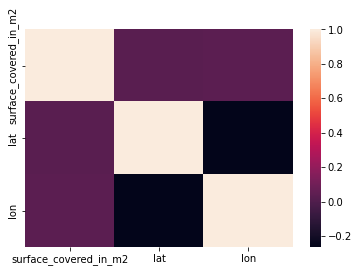

In [16]:
corr = df.select_dtypes("number").drop(columns=["price_aprox_usd", "Unnamed: 0"]).corr()
sns.heatmap(corr)

In [17]:
target = "price_aprox_usd"
features = ["surface_covered_in_m2", "lat", "lon", "neighborhood"]
X_train = df[features]
y_train = df[target]

In [18]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean]*len(y_train)
print("Mean apt price:", round(y_mean, 2))

print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean apt price: 132383.84
Baseline MAE: 44860.10834274133


In [19]:
ohe = OneHotEncoder(use_cat_names=True)

ohe.fit(X_train)

XT_train = ohe.transform(X_train)

In [20]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    Ridge()
)

model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [21]:
y_pred_training = model.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train, y_pred_training))

Training MAE: 24207.10719033026


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             6582 non-null   int64  
 1   price_aprox_usd        6582 non-null   float64
 2   surface_covered_in_m2  6582 non-null   float64
 3   lat                    6316 non-null   float64
 4   lon                    6316 non-null   float64
 5   neighborhood           6582 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 308.7+ KB


In [29]:
# X_test = pd.read_excel("/content/features.xlsx")
# X_test.drop(columns="Unnamed: 0", inplace=True)
# X_test.head()

,surface_covered_in_m2,lat,lon,neighborhood
0,47,-34.615310,-58.361983,Puerto Madero
1,55,-34.547298,-58.462705,Nuñez
2,34,-34.617762,-58.383662,Monserrat
3,34,-34.639925,-58.438406,Parque Chacabuco
4,42,-34.611495,-58.442359,Caballito


In [31]:
X_test = pd.read_excel("/content/features.xlsx")
X_test.drop(columns="Unnamed: 0", inplace=True)
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    231122.403569
1    162572.942392
2     68477.949626
3     63521.438989
4    105694.463885
dtype: float64

In [32]:
def make_prediction(area, lat, lon, neighborhood):
    data = {
        "surface_covered_in_m2": area,
        "lat": lat,
        "lon": lon,
        "neighborhood": neighborhood
    }
    df = pd.DataFrame(data, index=[0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"

In [33]:
make_prediction(110, -34.60, -58.46, "Villa Crespo")

'Predicted apartment price: $250775.11'

In [34]:
interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    neighborhood=Dropdown(options=sorted(X_train["neighborhood"].unique())),
);

interactive(children=(IntSlider(value=53, description='area', max=101, min=30), FloatSlider(value=-34.59890626…